# Twist solver

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from scipy import misc
from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from skimage.data import camera
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *

## 1D Sparsity

To begin we try to compare TWIST with other popular sparsity-promoting solvers in a basic example of compressed sensing (https://pylops.readthedocs.io/en/latest/gallery/plot_ista.html#sphx-glr-gallery-plot-ista-py)

ISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 15 rows and 20 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 100
alpha = 3.166566e-01	thresh = 1.583283e-03
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   1.49572e-01   2.991e-01   3.246e-01   7.213e-01
     2   1.61476e-01   1.446e-01   1.763e-01   2.503e-01
     3   1.56941e-01   9.048e-02   1.245e-01   1.419e-01
     4   1.49771e-01   6.371e-02   9.872e-02   9.754e-02
     5   1.42516e-01   4.754e-02   8.297e-02   7.475e-02
     6   1.35676e-01   3.655e-02   7.214e-02   6.119e-02
     7   1.29344e-01   2.859e-02   6.429e-02   5.182e-02
     8   1.23519e-01   2.260e-02   5.833e-02   4.493e-02
     9   1.18300e-01   1.808e-02   5.391e-02   3.865e-02
    10   1.13741e-01   1.454e-02   5.048e-02   3.418e-02
    11   1.09770e-01   1.174e-02   4.776e-02   3.040e-02
    21   9.14206e-02   1.

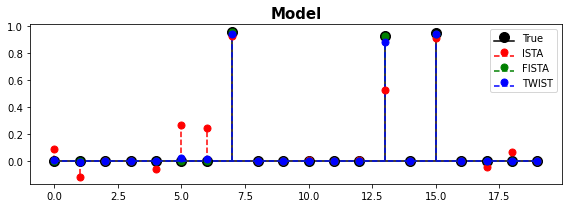

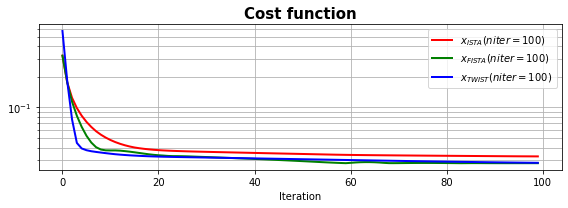

In [2]:
np.random.seed(0)

N, M = 15, 20
A = np.random.randn(N, M)
A = A / np.linalg.norm(A, axis=0)
Aop = MatrixMult(A)

x = np.random.rand(M)
x[x < 0.9] = 0
y = Aop*x

eps = 1e-2
maxit = 100

# ISTA
x_ista, niteri, costi = ISTA(Aop, y, maxit, eps=eps, tol=1e-10, show=True, returninfo=True)
# FISTA
x_fista, niterf, costf = FISTA(Aop, y, maxit, eps=eps, tol=1e-10, show=True, returninfo=True)
# TWIST
l1 = L1(sigma=eps)
eigs = (Aop.H * Aop).eigs()
eigs = (np.abs(eigs[0]), 5e-1)
x_twist, costt = TwIST(l1, Aop, y, eigs=eigs, x0=np.zeros(M), niter=maxit, show=True, returncost=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
m, s, b = ax.stem(x, linefmt='k', basefmt='k',
                  markerfmt='ko', label='True')
plt.setp(m, markersize=10)
m, s, b = ax.stem(x_ista, linefmt='--r', basefmt='--r',
                  markerfmt='ro', label='ISTA')
plt.setp(m, markersize=7)
m, s, b = ax.stem(x_fista, linefmt='--g', basefmt='--g',
                  markerfmt='go', label='FISTA')
plt.setp(m, markersize = 7)
m, s, b = ax.stem(x_twist, linefmt='--b', basefmt='--b',
                  markerfmt='bo', label='TWIST')
plt.setp(m, markersize = 7)
ax.set_title('Model', size=15, fontweight='bold')
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.semilogy(costi, 'r', lw=2, label=r'$x_{ISTA} (niter=%d)$' % niteri)
ax.semilogy(costf, 'g', lw=2, label=r'$x_{FISTA} (niter=%d)$' % niterf)
ax.semilogy(costt, 'b', lw=2, label=r'$x_{TWIST} (niter=%d)$' % maxit)
ax.set_title('Cost function', size=15, fontweight='bold')
ax.set_xlabel('Iteration')
ax.legend()
ax.grid(True, which='both')
plt.tight_layout()

## 2D Deblurrring

We try to solve the deconvolution problem:

$$
arg \;  min_\mathbf{u} \frac{\lambda}{2}||\mathbf{Ku-f}||_2^2 + J(\mathbf{u})
$$

where $\mathbf{K}$ is a convolutional operator with a kernel $k$, and different choices of regularization:

- Isotropic TV $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_{2,1}$


Finally we compare the convergence properties of Twist with ISTA and FISTA.

In [3]:
def callback(x):
    mhist.append(x)

Data and operators preparation

In [4]:
# Load image
img = camera()
ny, nx = img.shape

In [5]:
# Smoothing operator
nk = 9
k = np.ones((9, 9)) / nk**2
Kop = Convolve2D(ny*nx, k, dims=(ny, nx), offset=(nk//2, nk//2))

imgblur = (Kop * img.ravel()).reshape(ny, nx)

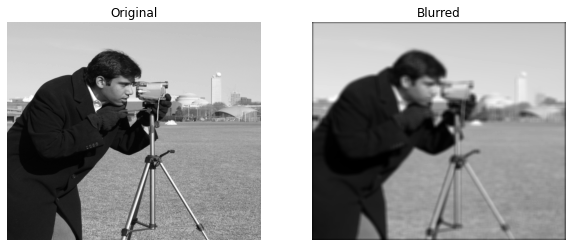

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(imgblur, cmap='gray')
axs[1].set_title('Blurred')
axs[1].axis('off')
axs[1].axis('tight');

## Isotropic TV

In [7]:
# L2 data term
lamda = 1.
l2 = L2(Op=Kop, b=imgblur.ravel(), sigma=lamda)

# Isotropic TV
sampling = 1.
sigma = 0.1
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')
l1iso = L21(ndim=2, sigma=sigma)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1 / np.sqrt(L)
mu = 1. / (tau*L)

imtv = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                  x0=np.zeros_like(img.ravel()), gfirst=False,
                  niter=100, show=True)
imtv = imtv.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 3.535534e-01	mu = 3.535534e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.11080e+01   1.538e+09   1.608e+04   0.000e+00       1.538e+09
     2   2.05929e+01   8.480e+08   2.853e+04   0.000e+00       8.480e+08
     3   2.87143e+01   4.686e+08   3.836e+04   0.000e+00       4.687e+08
     4   3.57189e+01   2.597e+08   4.621e+04   0.000e+00       2.598e+08
     5   4.18043e+01   1.446e+08   5.253e+04   0.000e+00       1.446e+08
     6   4.71288e+01   8.095e+07   5.769e+04   0.000e+00       8.101e+07
     7   5.18203e+01   4.573e+07   6.201e+04   0.000e+00       4.579e+07
     8   5.59823e+01   2.616e+07   6

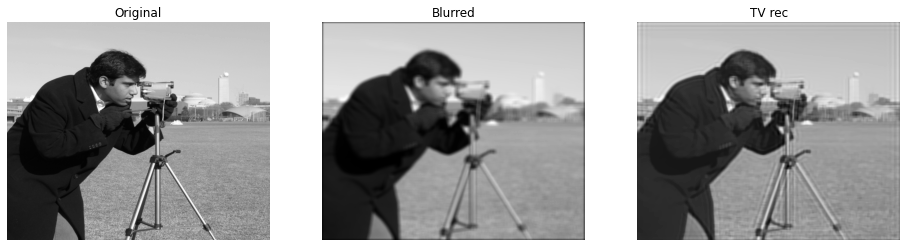

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(imgblur, cmap='gray')
axs[1].set_title('Blurred')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imtv, cmap='gray')
axs[2].set_title('TV rec')
axs[2].axis('off')
axs[2].axis('tight');

In [9]:
from pyproximal.proximal.TV import TVaniso

emin = 1e-3
emax = 1
k = emin / emax
rho =  (1 - sqrt(k)) / (1 + sqrt(k))
alpha = 1 + rho ** 2
beta = 2 * alpha / (emax + emin)
beta

3.7585310908371135

In [10]:
tv = TVaniso((ny,nx), sigma=sigma)

tv.prox(img.ravel(), 1).shape, img.ravel().shape

In [13]:
imtwist = TwIST(tv, Kop, imgblur.ravel(), alpha=alpha, beta=beta, 
             x0=np.zeros_like(img.ravel()), niter=100, show=True)
imtwist = imtwist.reshape(img.shape)

2792466675.161027
TwIST
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.TV.TVaniso'>
Linear operator (A): <class 'pylops.signalprocessing.ConvolveND.ConvolveND'>
alpha = 1.881145e+00	beta = 3.758531e+00	niter = 100

   Itn       x[0]          f           g       J = f + g


ValueError: operands could not be broadcast together with shapes (262144,) (524288,) 

# Wavelet sparsity

In [14]:
# L2 data term
lamda = 1.
Qop = DWT2D(img.shape, wavelet='haar', level=2)
l2 = L2(Op=Kop*Qop, b=imgblur.ravel(), sigma=lamda, niter=20)

# L1 Norm of Wavelet
sigma = 0.1
l1 = L1(sigma=sigma)

Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = 1.000000e+00	beta=5.000000e-01
epsg = 1.000000e+00	niter = 100	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g
     1   1.30107e+02   1.059e+07   2.832e+06   1.343e+07
     2   1.60051e+02   3.243e+06   2.874e+06   6.118e+06
     3   1.77006e+02   1.724e+06   2.884e+06   4.608e+06
     4   1.88283e+02   1.133e+06   2.889e+06   4.021e+06
     5   1.96559e+02   8.316e+05   2.891e+06   3.723e+06
     6   2.03045e+02   6.530e+05   2.893e+06   3.546e+06
     7   2.08366e+02   5.360e+05   2.894e+06   3.430e+06
     8   2.12873e+02   4.540e+05   2.894e+06   3.348e+06
     9   2.16781e+02   3.935e+05   2.895e+06   3.288e+06
    10   2.20228e+02   3.471e+05   2.895e+06   3.242e+06
    11   2.23309e+02   3.103e+05   2.895e+06   3.206e+06
    21   2.43248e+02   1.491e+05   2

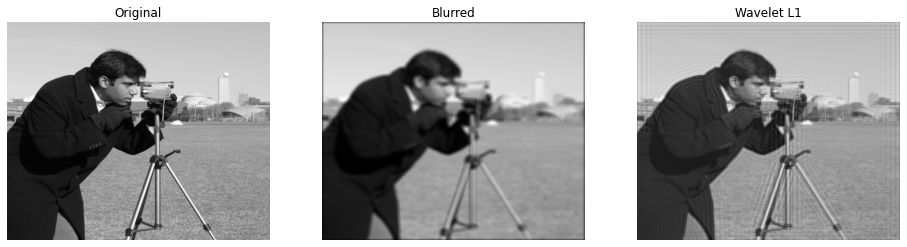

In [15]:
# Proximal gradient
tau = 1.
imq = ProximalGradient(l2, l1, x0=np.zeros_like(img.ravel()), tau=tau, niter=100, show=True)
imq = (Qop*imq).reshape(img.shape)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(imgblur, cmap='gray')
axs[1].set_title('Blurred')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imq, cmap='gray')
axs[2].set_title('Wavelet L1')
axs[2].axis('off')
axs[2].axis('tight');

1 1.8181818181818181
TwIST
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.LinearOperator.LinearOperator'>
alpha = 1.000000e+00	beta = 1.818182e+00	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.84688e+02   2.281e+06   2.917e+05   2.573e+06
     2   1.96204e+02   1.066e+06   2.882e+05   1.354e+06
     3   2.08713e+02   6.473e+05   2.910e+05   9.383e+05
     4   2.15512e+02   4.556e+05   2.894e+05   7.450e+05
     5   2.22264e+02   3.472e+05   2.908e+05   6.380e+05
     6   2.27033e+02   2.813e+05   2.900e+05   5.713e+05
     7   2.31535e+02   2.353e+05   2.907e+05   5.260e+05
     8   2.35148e+02   2.030e+05   2.903e+05   4.933e+05
     9   2.38464e+02   1.777e+05   2.907e+05   4.684e+05
    10   2.41325e+02   1.584e+05   2.905e+05   4.489e+05
    11   2.43923e+02   1.424e+05   2.907e+05   4.331e+05
    21   2.60570e+02   6.833e+04   2.909e+05   3.5

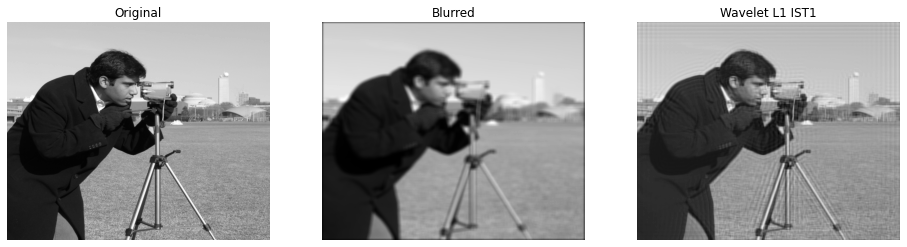

In [29]:
#IST
sigma = 0.01
l1 = L1(sigma=sigma)

alpha = 1
beta = 2 / (emax + emin) # 1
print(alpha, beta)

imist, jist = TwIST(l1, Kop * Qop, imgblur.ravel(), alpha=alpha, beta=beta, 
                    x0=np.zeros_like(img.ravel()), niter=100, show=True, returncost=True)
imist = (Qop*imist).reshape(img.shape)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(imgblur, cmap='gray')
axs[1].set_title('Blurred')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imist, cmap='gray')
axs[2].set_title('Wavelet L1 IST1')
axs[2].axis('off')
axs[2].axis('tight');

1.0853932672921147 1.6698357958340226
TwIST
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.LinearOperator.LinearOperator'>
alpha = 1.085393e+00	beta = 1.669836e+00	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.91360e+02   2.400e+07   3.151e+05   2.431e+07
     2   1.96088e+02   7.676e+06   2.760e+05   7.952e+06
     3   2.10262e+02   1.753e+06   2.957e+05   2.049e+06
     4   2.15961e+02   5.742e+05   2.880e+05   8.622e+05
     5   2.22722e+02   3.383e+05   2.910e+05   6.293e+05
     6   2.27539e+02   2.665e+05   2.901e+05   5.566e+05
     7   2.31887e+02   2.255e+05   2.905e+05   5.161e+05
     8   2.35546e+02   1.964e+05   2.905e+05   4.869e+05
     9   2.38788e+02   1.736e+05   2.906e+05   4.642e+05
    10   2.41650e+02   1.553e+05   2.906e+05   4.459e+05
    11   2.44219e+02   1.403e+05   2.906e+05   4.309e+05
    21   2.60765e+02   6.778e+04 

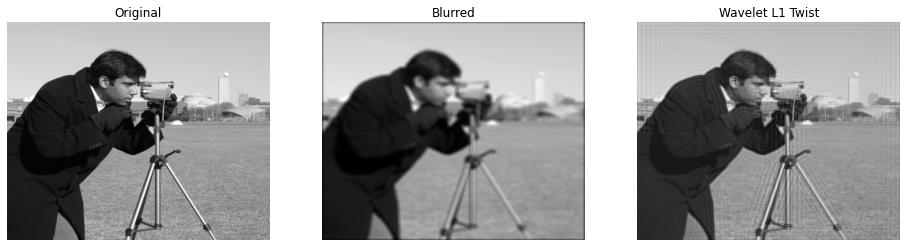

In [32]:
# TWIST
emin = 3e-1
emax = 1
k = emin / emax
rho =  (1 - sqrt(k)) / (1 + sqrt(k))
alpha = 1 + rho ** 2
beta = 2 * alpha / (emax + emin)
print(alpha, beta)

imtwist, jtwist = TwIST(l1, Kop * Qop, imgblur.ravel(), alpha=alpha, beta=beta, 
                        x0=np.zeros_like(img.ravel()), niter=100, show=True, returncost=True)
imtwist = (Qop*imtwist).reshape(img.shape)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(imgblur, cmap='gray')
axs[1].set_title('Blurred')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(imtwist, cmap='gray')
axs[2].set_title('Wavelet L1 Twist')
axs[2].axis('off')
axs[2].axis('tight');

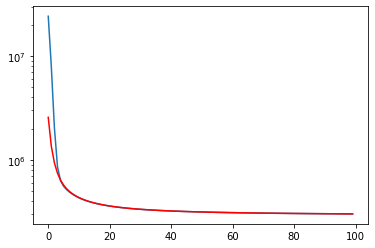

In [33]:
plt.semilogy(jtwist)
plt.semilogy(jist, 'r')